# DAS conversion to zarr

Converts ascii type data to zarr format


In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import dashydro.hydro as hy

---
## load ascii data and store as zarr

In [4]:
deployment = "2019_summer_toulon"

dinfo = hy.deployments_info[deployment]
#coords_path = os.path.join(hy.root_data_dir, "raw/cable_coords.csv") # old coordinate file
coords_path = os.path.join(dinfo["raw_dir"], "das_cable_coordinates_2021_MPA_corrected.h5") # new one
data_path = os.path.join(dinfo["raw_dir"], "DAST_Toulon_July2019_strain.txt")
time_path = os.path.join(dinfo["raw_dir"], "DAST_Toulon_July2019_time.txt")
site = dinfo["site"]

zarr = os.path.join(dinfo["processed_dir"], "dast_L0.zarr")

**load coordinates and depth**

In [17]:
_extension = coords_path.split(".")[-1]

if _extension==".csv":
    dfc = (pd.read_csv(coords_path)
           .rename(columns={"Unnamed: 0":"channel", 
                            "cable_lon":"lon", 
                            "cable_lat":"lat", 
                            "cable_depth":"depth"},
                  )
           .set_index("channel")
          )
    dfc.index = dfc.index.astype(int)
    coords = dict(channel=dfc.index, lon=dfc.lon, lat=dfc.lat,
                  depth=dfc.depth,
                 )
elif _extension=="h5":
    ds = xr.open_dataset(coords_path)
    ds = ds.rename(phony_dim_0="channel")
    coords = dict(channel=ds.channel, 
                  lon=ds.longitude, 
                  lat=ds.latitude, 
                  depth=ds.bathymetry,
                  slack=ds.slack,
                  grad_x=ds.grad_x,
                  grad_y=ds.grad_y,
                 )
    ds.to_netcdf(os.path.join(hy.root_data_dir, "common", f'coords_{site}.nc'))
    
ds

<xarray.Dataset>
Dimensions:     (channel: 4480)
Dimensions without coordinates: channel
Data variables:
    bathymetry  (channel) float64 ...
    depth       (channel) float64 ...
    grad_x      (channel) float64 ...
    grad_y      (channel) float64 ...
    latitude    (channel) float64 ...
    longitude   (channel) float64 ...
    slack       (channel) float64 ...

<xarray.Dataset>
Dimensions:     (channel: 4480)
Dimensions without coordinates: channel
Data variables:
    bathymetry  (channel) float64 -5.499 -5.296 -5.093 ... 2.429e+03 2.43e+03
    depth       (channel) float64 0.0 0.0 0.0 ... 2.393e+03 2.393e+03 2.393e+03
    grad_x      (channel) float64 -0.03457 -0.03406 -0.03355 ... 0.01335 0.0098
    grad_y      (channel) float64 0.03799 0.03678 0.03556 ... 0.0287 0.02977
    latitude    (channel) float64 43.09 43.09 43.09 43.09 ... 42.81 42.81 42.81
    longitude   (channel) float64 5.899 5.899 5.899 5.899 ... 6.015 6.015 6.015
    slack       (channel) float64 0.0 0.0 0.0 0.0 0.0 ... 26.2 26.2 26.2 26.2

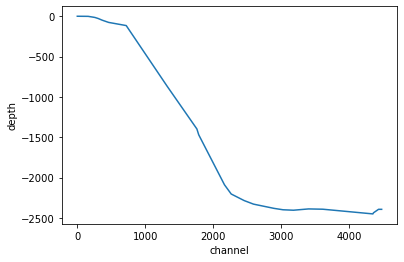

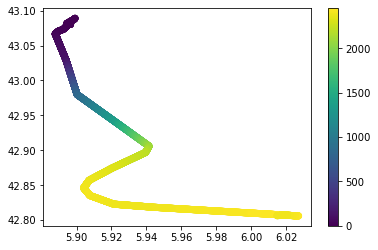

In [19]:
fig, ax = plt.subplots(1,1)
(-ds.depth).plot(ax=ax)

fig, ax = plt.subplots(1,1)
im = ax.scatter(ds.longitude, ds.latitude, c=ds.depth)
fig.colorbar(im)

ds

**load time**

In [26]:
dft = pd.read_csv(time_path, names=["time"], skiprows=1, parse_dates=["time"])
coords["time"] = dft.time.values

**Read core DAS temperature data**

In [7]:
df = pd.read_csv(data_path, sep=" ", names=list(dft.index), skiprows=1)

In [27]:
ds = xr.Dataset(dict(strain=(("channel", "time"), np.array(df))),
                coords=coords
               )
ds = ds.chunk(dict(channel="auto"))

In [28]:
# write zarr archive
ds.to_zarr(zarr, mode="w")

---

## inspect data


In [3]:
ds = xr.open_zarr(zarr)

In [11]:
dt = float((ds.time[1]-ds.time[0])/pd.Timedelta("1T"))
print(f"Time sampling : dt = {dt} min")

Time sampling : dt = 2.0 min


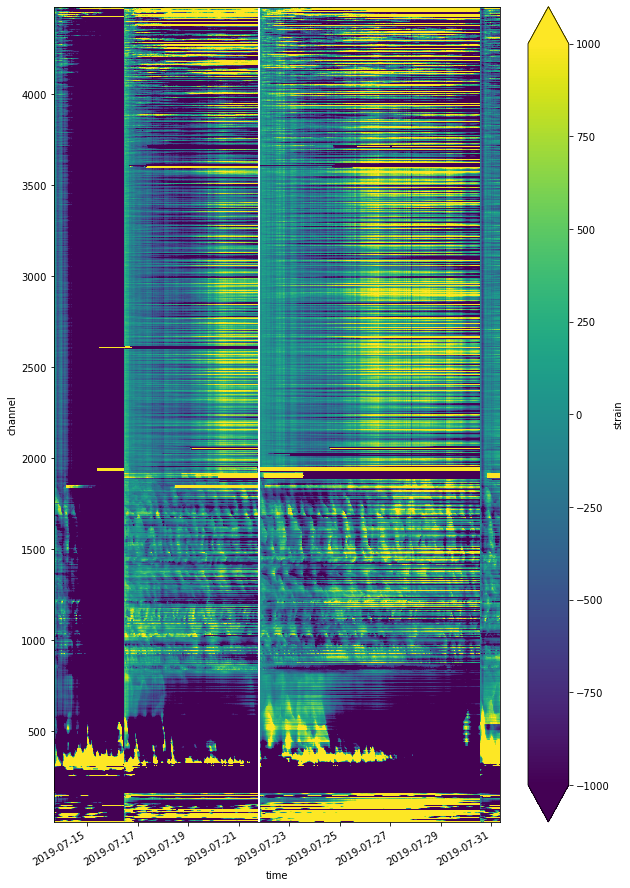

In [15]:
_da = ds.strain.isel(time=slice(0,None,15))
_da.plot(vmin=-1e3, vmax=1e3, figsize=(10,15))
#np.log10(_da).plot(figsize=(10,10))

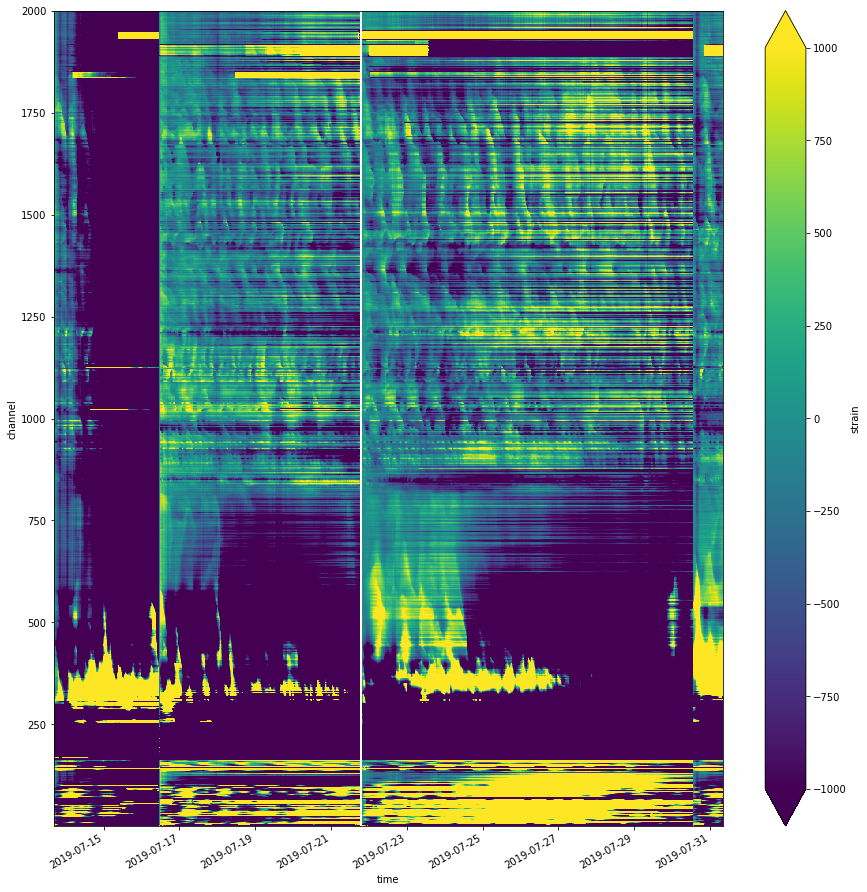

In [19]:
_da = ds.strain.isel(time=slice(0,None,15), channel=slice(0,2000))
_da.plot(vmin=-1e3, vmax=1e3, figsize=(15,15))
#np.log10(_da).plot(figsize=(10,10))